<img src="../img/ods_stickers.jpg" />

## 集成学习和随机森林方法

---

#### 介绍

本次实验介绍了集成学习的概念及主要方法，包括 Bootstraping、Bagging、随机森林，随后计算随机森林中各个特征的重要性，找出对模型贡献较大的特征。

#### 知识点

- 集成
- Bootstraping
- Bagging
- 随机森林
- 特征重要性

---

### 集成

之前的几个实验中，介绍了不同的分类算法，以及验证、评估模型的技术。现在，假设已经为某一特定问题选中了最佳的模型，想进一步提升其准确率，就需要应用一些更高级的机器学习技术：集成（Ensemble）。集成是使用一系列学习器进行学习，并使用某种规则把各个学习结果进行整合从而获得比单个学习器更好的学习效果的一种机器学习方法。在集成中，最终的整体输出比任何单个部分的表现更重要。

某种意义上，孔多塞陪审团定理形象的描述了上面提到的集成概念。该定理的内容为：如果评审团的每个成员做出独立判断，并且每个陪审员做出正确决策的概率高于 0.5，那么整个评审团做出正确的总体决策的概率随着陪审员数量的增加而增加，并趋向于一。另一方面，如果每个陪审员判断正确的概率小于 0.5，那么整个陪审团做出正确的总体决策的概率随着陪审员数量的增加而减少，并趋向于零。

该定理的公式为：

$$  \mu = \sum_{i=m}^{N}{N\choose i}p^i(1-p)^{N-i} $$

其中，

- $N$ 为陪审员总数。
- $m$ 是构成多数的最小值，即 $m=\operatorname{floor}(N / 2)+1$。
- $ {N \choose i}$ 是组合数。
- $ p$ 为评审员做出正确决策的概率。
- $ \mu$ 是整个评审团做出正确决策的概率。

由上式可知，若 $ p > 0.5$，则 $ \mu > p$。此外，若  $ N \rightarrow \infty $，则 $ \mu \rightarrow 1$。

让我们看看另一个集成的例子：群体的智慧。1906 年，Francis Galton 访问了普利茅斯的一个农村集市，在那里他看到一个比赛。800 个参与者尝试估计一头屠宰的牛的重量。所有参与者的预测的平均值为 1197 磅，与牛的真实重量 1198 磅十分接近。

机器学习领域采用类似的思路以降低误差。

### Bootstrapping

Leo Breiman 于 1994 年提出的 Bagging（又称 Bootstrap Aggregation，引导聚集）是最基本的集成技术之一。Bagging 基于统计学中的 Bootstraping（自助法），该方法令复杂模型的统计评估变得更加可行。

Bootstrap 方法的流程如下：假设有尺寸为 N 的样本 X，从该样本中有放回地随机抽取 N 个样本，以创建一个新样本。换句话说，从尺寸为 N 的原样本中随机选择一个元素，并重复此过程 N 次。选中所有元素的可能性是一样的，因此每个元素被抽中的概率均为 $ \frac{1}{N}$。

假设用 Bootstrap 方法从一个袋子中抽球，每次抽一个。在每一步中，将选中的球放回袋子，这样下一次抽取是等概率的，即，从同样数量的 N 个球中抽取。注意，因为我们把球放回了，新样本中可能有重复的球。把这个新样本称为 $ X_1$。重复这一过程 M 次，创建 M 个 Bootstrap 样本 $ X_1, \dots, X_M$。最后，我们的样本数量就从原先的 1 个扩充到了 M 个，就有充足的样本来计算原始分布的多种统计数据。

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032611491">

看一个例子，这个例子使用之前的 telecom_churn 数据集。我们曾讨论过这一数据集的特征重要性，其中最重要的特征之一是呼叫客服次数（Customer service calls）。可视化「呼叫客服次数」这一特征，看看其分布。

In [1]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline
warnings.filterwarnings('ignore')

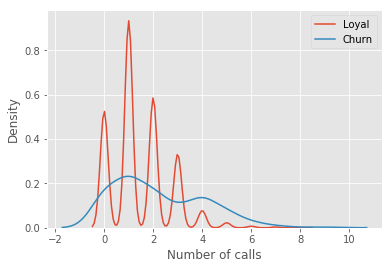

In [2]:
telecom_data = pd.read_csv(
    '../../data/telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == True]['Customer service calls'], label='Churn')
fig.set(xlabel='Number of calls', ylabel='Density')
plt.show()

上图表明，相比那些逐渐离网的客户，忠实客户呼叫客服的次数更少。估计每组客户的平均呼叫客服数可能很有用，但由于该数据集很小，如果直接计算原样本的均值，得到的估计可能较差。因此可以应用 Bootstrap 方法，基于原样本生成 1000 个新 Bootstrap 样本，然后计算均值的区间估计。

定义 `get_bootstrap_samples()` 函数产生 Bootstrap 样本，定义 `stat_intervals()` 函数产生一个区间估计。

In [3]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

分割数据集，分组为忠实客户和离网客户。

In [4]:
loyal_calls = telecom_data.loc[telecom_data['Churn'] == False,
                               'Customer service calls'].values
churn_calls = telecom_data.loc[telecom_data['Churn'] == True,
                               'Customer service calls'].values

固定随机数种子，以得到可重现的结果。

In [5]:
np.random.seed(0)

使用 Bootstrap 生成样本，计算各自的均值。

In [6]:
loyal_mean_scores = [np.mean(sample)
                     for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample)
                     for sample in get_bootstrap_samples(churn_calls, 1000)]

打印区间估计值，使用 `stat_intervals()` 函数将区间定义为 95%。

In [7]:
print("Service calls from loyal: mean interval",
      stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn: mean interval",
      stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


上述结果表明，有 95% 的概率，忠实客户平均呼叫客服的次数在 1.4 到 1.49 之间，而离网客户平均呼叫客服的次数在 2.06 到 2.40 之间。另外，可以注意到忠实客户的区间更窄，这是合理的，因为相比多次呼叫客服的离网客户，忠实客户呼叫客服的次数更少（0、1、2 次）。

### Bagging

理解了 Bootstrap 概念之后，接下来介绍 Bagging。

假设我们有一个训练集 X。我们使用 Bootstrap 生成样本 $ X_1, \dots, X_M$。现在，我们在每个 Bootstrap 样本上分别训练分类器 $ a_i(x)$，最终的分类器将对所有这些单独的分类器的输出取均值。在分类情形下，这种技术即投票（voting）：

$$ a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x).$$

下图形象化解释了上面的公式：

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032635677">

在回归问题中，通过对回归结果取均值，Bagging 将均方误差降至 $\frac{1}{M}$（M 为回归器数量）。

回顾一下上一课的内容，模型的预测误差由三部分构成：

$$ \mathrm{Bias}\left(\hat{f}\right)^2 + \mathrm{Var}\left(\hat{f}\right) + \sigma^2$$

Bagging 通过在不同数据集上训练模型的方式来降低分类器的方差。换句话说，Bagging 可以预防过拟合。由于来自不同训练数据集上的模型各不相同，它们的误差在投票过程中会相互抵消，所以 Bagging 是有效的。此外，某些 Bootstrap 训练样本很可能会忽略异常值。

让我们看下 Bagging 的实际效果，并与决策树比较下，如下图所示：

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032656840">

决策树的误差：

$$0.0255 (\mathrm{Err}) = 0.0003 (\mathrm{Bias}^2)  + 0.0152 (\mathrm{Var}) + 0.0098 (\sigma^2) $$

Bagging 的误差：

$$  0.0196 \, (\mathrm{Err}) = 0.0004 \, (\mathrm{Bias}^2)  + 0.0092 \, (\mathrm{Var}) + 0.0098 \, (\sigma^2) $$  

从上图可以看到，相比决策树，Bagging 误差中的方差值显著降低了。

上图的例子不太可能在实际工作中出现，因为它做了一个强假定：单独误差是不相关的。对现实世界的应用而言，这个强假定太过乐观。当这个假定不成立时，误差的下降就不会那么显著。在后续实验中，我们将讨论一些更复杂的集成方法，能够对现实世界的问题做出更精确的预测。

### 袋外误差（OOB Error）

随机森林不需要使用交叉验证或留置样本，因为它内置了误差估计。随机森林中的决策树基于原始数据集中不同的 Bootstrap 样本构建。对第 K 棵树而言，其特定 Bootstrap 样本大约留置了 37% 的输入。

这很容易证明。设数据集中有 $ \ell$ 个样本。在每一步，每个数据点最终出现在有放回的 Bootstrap 样本中的概率均为 $\frac{1}{\ell}$。Bootstrap 样本最终不包含特定数据集元素的概率（即，该元素在 $\ell$  次抽取中都没抽中）等于 $ (1 - \frac{1}{\ell})^\ell$。当 $ \ell \rightarrow +\infty$ 时，这一概率等于  $ \frac{1}{e}$。因此，选中某一特定样本的概率 $ \approx  1 - \frac{1}{e} \approx 63\%$。

下图可视化袋外误差（Out-of-Bag Error，OOBE）估计是如何工作的：

<img width='400px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032680775">

示意图上方为原始数据集。将其分为训练集（左图）和测试集（右图）。在测试集上，绘制一副网格，完美地实现了分类。现在，我们应用同一副网格到测试集上，以估计分类的正确率。右图可见，分类器在 4 个未曾在训练集中出现的数据点上给出了错误的答案。而测试集中共有 15 个数据点，这 15 个数据点未在训练集中出现。因此，该分类器的准确率为 $ \frac{11}{15}*100\% = 73.33\%$。

总结一下，每个基础算法在约 63% 的原始样本上训练。该算法可以在剩下的约 37% 的样本上验证。袋外估计仅仅是基础算法在 37% 样本上的平均估计。

### 随机森林

在 Bagging 中，主要使用的基础分类器为决策树，因为决策树相当复杂，并能在任何样本上达到零分类误差。随机子空间方法可以降低树的相关性，从而避免过拟合。基于 Bagging，基础算法会在不同的原始特征集的随机子集上训练。

以下算法使用随机子空间方法构建集成模型：

- 设样本数等于 n，特征维度数等于 d。
- 选择模型的数目 M。
- 对于每个模型 m，选择特征数 dm<d。所有模型使用相同的 dm 值。
- 对每个模型 m，通过在整个 d 特征集合上随机选择 dm 个特征创建一个训练集。
- 训练每个模型。
- 通过组合 M 个模型的结果，将生成的整体模型应用于新数据中，应用时可以基于多数投票算法（majority voting）或后验概率聚合（aggregation of the posterior probabilities）。

#### 随机森林的算法

构建 N 棵树的随机森林算法如下：

- 对每个 $ k = 1, \dots, N$，生成 Bootstrap 样本 $ X_k$。
- 在样本 $ X_k$ 上创建一棵决策树 $ b_k$：
  - 根据给定的标准选择最佳的特征维度。根据该特征分割样本以创建树的新层。重复这一流程，直到样本用尽。
  - 创建树，直到任何叶节点包含的实例不超过 $ n_\text{min}$ 个，或者达到特定深度。
  - 每次分割，首先从 $d$ 个原始特征中随机选择 $m$ 个特征，接着只在该子集上搜索最佳分割。

最终分类器定义为：

$$ a(x) = \frac{1}{N}\sum_{k = 1}^N b_k(x)$$

分类问题使用多数投票算法，回归问题使用均值。在分类问题中，建议设定 $ m = \sqrt{d}$，取 $ n_\text{min} = 1$。回归问题中，一般取 $ m = \frac{d}{3}$，$ n_\text{min} = 5$。

可以将随机森林看成 Bagging 决策树的一个改动版本，因为随机森林在每个 Bagging 决策树的分割处选择了一个随机特征子空间。

#### 随机森林与 Bagging 和决策树的比较

导入所需包，配置环境：

In [8]:
from __future__ import division, print_function
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt

# Disable warnings in Anaconda
import warnings
import numpy as np
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6


n_train = 150
n_test = 1000
noise = 0.1

生成数据。

In [9]:
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

使用单棵决策树回归。

Text(0.5, 1.0, 'Decision tree, MSE = 20.09')

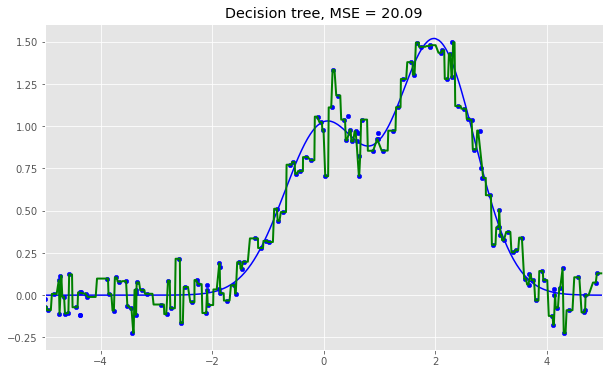

In [10]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f"
          % np.sum((y_test - d_predict) ** 2))

使用 Bagging 决策树回归。

Text(0.5, 1.0, 'Bagging for decision trees, MSE = 15.24')

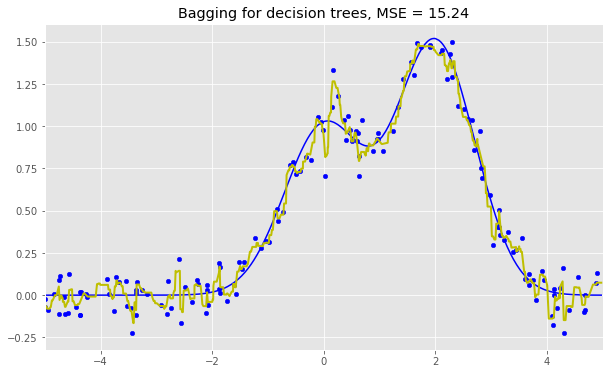

In [11]:
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Bagging for decision trees, MSE = %.2f" %
          np.sum((y_test - bdt_predict) ** 2))

使用随机森林。

Text(0.5, 1.0, 'Random forest, MSE = 15.71')

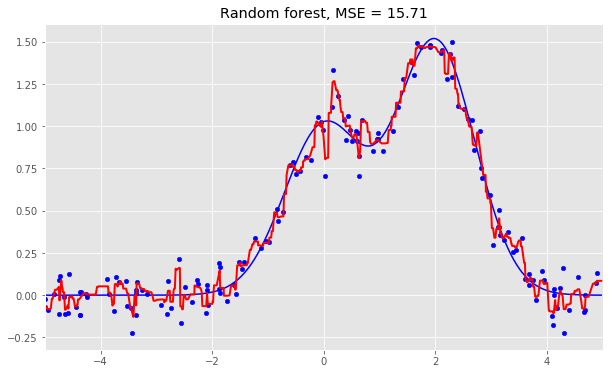

In [12]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))

从上面 3 张图像和 MSE 值可以看到，10 树随机森林比单棵决策树和 10 树 Bagging 的表现要好，当然随机森林在这个例子上不稳定，多次运行结果表明随机森林和 Bagging 决策树互有胜负。随机森林和 Bagging 的主要差别在于，前者分割的最佳特征是从一个随机特征子空间中选取的，而后者在分割时将考虑所有特征。

接下来，我们将查看随机森林和 Bagging 在分类问题上的表现。

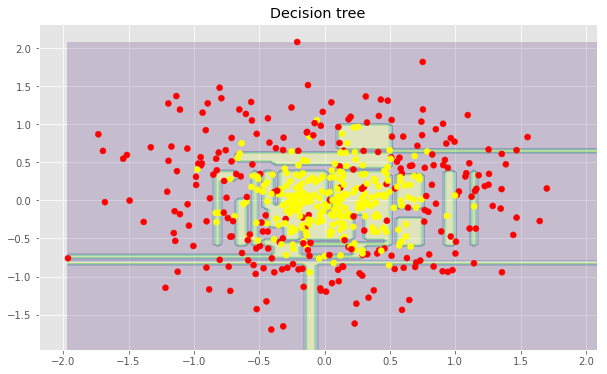

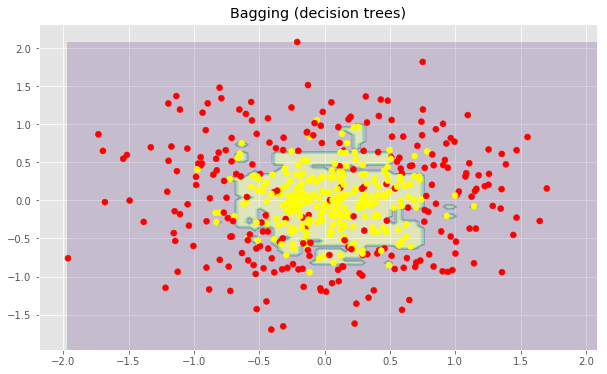

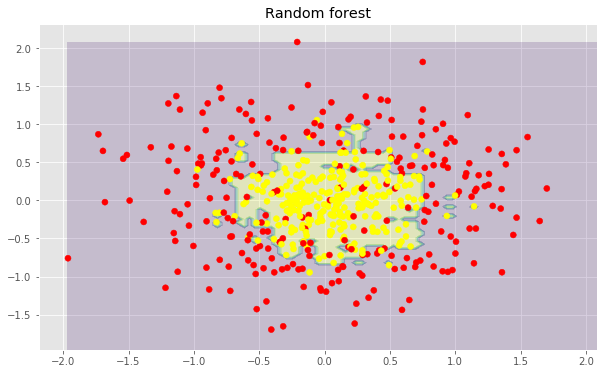

In [13]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(
    X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Decision tree")
plt.show()

b_dtree = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Bagging (decision trees)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Random forest")
plt.show()

上图显示了决策树形成的边界凹凸不平，有大量锐角，这暗示出现过拟合现象。相反，随机森林和 Bagging 的边界相当平滑，没有明显的过拟合的迹象。

现在，看看哪些参数有利于提高随机森林模型的准确率。

#### 随机森林的参数

scikit-learn 库提供了 `BaggingRegressor` 和 `BaggingClassifier` 类，其中在创建新模型时需要注意的一些参数如下：

- n_estimators 是随机森林中树的数量；
- criterion 是衡量分割质量的函数；
- max_features 是查找最佳分割时考虑的特征数；
- min_samples_leaf 是叶节点的最小样本数；
- max_depth 是树的最大深度。

#### 随机森林在现实问题中的应用

使用之前运营商的客户离网数据集作为例子。这是一个分类问题，使用准确率评估模型。

首先，创建一个简单的分类器作为基线。出于简单的目的，只使用数值特征构建分类器。

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

加载数据集。

In [15]:
df = pd.read_csv(
    "../../data/telecom_churn.csv")

选择数值特性。

In [16]:
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

将数据集分离为输入变量和目标变量。

In [17]:
X, y = df[cols].copy(), np.asarray(df["Churn"], dtype='int8')

为验证过程进行分层分割。

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

基于默认参数初始化分类器。

In [19]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

在训练集上进行训练。

In [20]:
results = cross_val_score(rfc, X, y, cv=skf)

在测试集上评估准确率。

In [21]:
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 91.48%


得到了 91.48% 的准确率作为基线，现在，尝试改进结果，同时查看一下基本参数变化时的学习曲线。首先，从改进树的数量开始，初始化 K 折交叉验证。

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

创建列表储存训练集和测试集上的准确率。

In [23]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []

进行网格搜索。下方列表中候选数值较多，会增加线上环境执行时间，可以自行减少数量以加快运行。

In [24]:
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

在训练集上训练模型。

In [25]:
for ntrees in trees_grid:
    rfc = RandomForestClassifier(
        n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

In [26]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100,
                                                            trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.44% with 50 trees


更改树的数量为 50 时，得到了 92.44% 的准确率。接下来，绘制相应的学习曲线。

Text(0.5, 0, 'N_estimators')

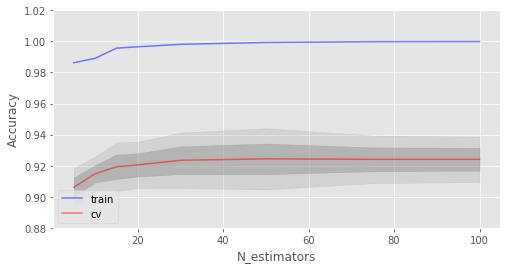

In [27]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

上图表明，当树的数量增加到一定值时，测试集上的准确率不再提升，同时训练集上的准确率达到了 100%，这意味着出现过拟合。

为了避免过拟合，需要给模型加上正则化参数。下面将树的数目固定为 100，然后看看不同的 max_depth 效果如何，首先创建列表以保存训练和测试集上的准确率。

In [28]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

在训练集上训练模型。

In [29]:
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.68% with 17 max_depth


Text(0.5, 0, 'Max_depth')

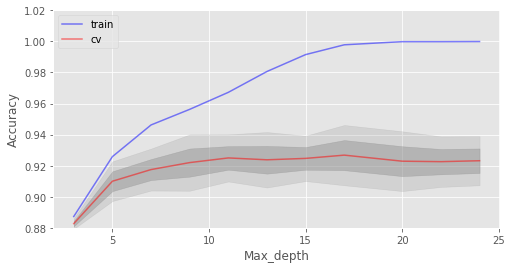

In [30]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100,
                                                                max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

max_depth 在模型中起到了正则化的作用，过拟合现象有所缓解，模型准确率提高了一些。

另一个值得调整的重要参数是 min_samples_leaf，它也能起到正则化作用。首先，创建列表以保存训练和测试集上的准确率。

In [31]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

在训练集上训练模型。

In [32]:
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.41% with 3 min_samples_leaf


Text(0.5, 0, 'Min_samples_leaf')

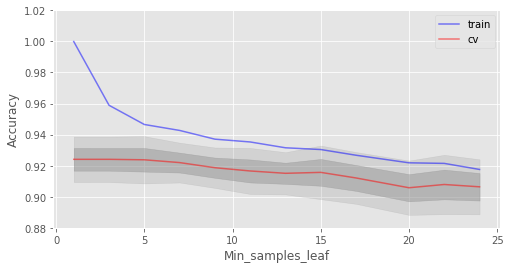

In [33]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100,
                                                                       min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(
    axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(
    axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

在这一情形下，验证集上的准确率没有提高，但当验证集的准确率保持 92%以上时，过拟合的情况降低了 2%。

下面考虑 max_features 这一参数。在分类问题中，默认特征为「所有特征数的平方根」。首先，检查在这个例子中选择 4 个特征是否是最佳的，创建列表以保存训练和测试集的准确率。

In [34]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

在训练集上训练模型。

In [35]:
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.59% with 12 max_features


Text(0.5, 0, 'Max_features')

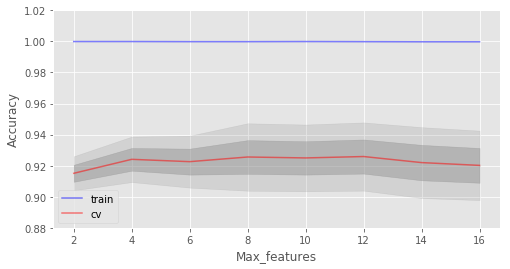

In [36]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100,
                                                                   max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

上图表明，在这个例子中，max_features=12 时模型表现最好。

我们已经看到学习曲线如何随着基本参数的变化而变化。现在，直接使用 `GridSearch()` 来查找最佳参数。首先，初始化参数集以进行穷举搜索和拟合。

In [37]:
# 原实验搜索参数
# parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [
#     1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]}
# 为加速线上环境执行，优化搜索参数
parameters = {'max_features': [10, 13], 'min_samples_leaf': [1, 3], 'max_depth': [5, 10]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42,
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   33.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [10, 13], 'min_samples_leaf': [1, 3], 'max_depth': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

打印结果。

In [38]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
             oob_score=True, random_state=42, verbose=0, warm_start=False),
 0.9270927092709271)

调参之后，该模型的准确率达到了 92.7%。随机森林最重要的一点是它的准确率不会随着树的增加而下降，这意味着可以使用 10 棵树调整超参数，接着把树的数量从 10 增至 500 来提升准确率。

#### 随机森林的方差和去相关

随机森林的方差可以用下式表达：

$$ \mathrm{Var} f(x) = \rho(x)\sigma^2(x)$$

$$ \rho(x) = \mathrm{Corr}\left[T(x_1,\Theta_1(Z)),T(x_2,\Theta_2(Z))\right],$$

其中，

- $ \rho(x)$ 为任意两棵树之间的样本相关性；
- $ \Theta_1(Z)$ 和 $ \Theta_2(Z)$ 为在样本 $Z$ 的随机元素上，随机选择的一对树；
- $ T(x,\Theta_i(Z))$ 为第 $i$ 个树分类器在输入向量 $x$ 上的输出；
- $ \sigma^2(x)$ 为任何随机选择的树上的样本方差：$\sigma^2(x) = \mathrm{Var}\left[T(x,\Theta(X))\right]$

很容易将 $ \rho(x)$ 误认为随机森林中已完成训练的树的平均相关性，其实并非如此。$ \rho(x)$ 是一对随机树在输入 $x$ 上估计的理论相关性，它的值源自重复取样训练集以及之后随机选择的决策树对。用统计学术语来说，这个相关性是由 $ Z$ 和 $ \Theta$ 的取样分布导致的。

任何一对树的条件相关性等于 0，因为 Bootstrap 和特征选取是独立同分布。如果考虑单棵树的方差，它几乎不受分割参数的影响（$ m$），但分割参数在集成中是关键参数。另外，单棵决策树的方差要比集成高很多，如下图所示：（图来自《The Elements of Statistical Learning》）

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032735764">

#### 随机森林的偏差

随机森林、Bagging 的偏差和单棵决策树一样：

$$\begin{array}{rcl} \mathrm{Bias} &=& \mu(x) - \mathrm{E}_Z \, f_{rf}(x) \\
&=& \mu(x) - \mathrm{E}_Z \, \mathrm{E}_{\Theta | Z} \, T(x,\Theta(Z))\end{array}$$  

从绝对值上说，随机森林和 Bagging 的偏差通常比单棵决策树要大，因为随机过程和样本空间缩减使得模型受到了限制。因此，Bagging 和随机森林在预测准确率上比单棵决策树要高的原因仅仅源自方差的降低。

####  极端随机树

极端随机树（Extremely Randomized Trees）在节点分岔时应用了更多随机性。和随机森林一样，极端随机树使用一个随机特征子空间。然而，极端随机数并不搜寻最佳阈值，相反，它为每个可能的特征随机生成一个阈值，然后挑选最佳阈值对应的特征来分割节点，通过增加少量偏差来降低方差。

scikit-learn 库的 `ExtraTreesClassifier()` 和 `ExtraTreesRegressor()` 类实现了该方法。如果使用随机森林或梯度提升遇到了严重的过拟合，可以试试极端随机树。

#### 随机森林和 k 近邻的相似性 

随机森林和 k-近邻方法有相似之处。随机森林的预测基于训练集中相似样本的标签，这些样本越常出现在同一叶节点，它们的相似度就越高。

下面来证明这一点，考虑一个二次损失函数的回归问题：设 $ T_n(x)$ 为输入 $x$ 在随机森林中第 $n$ 棵树的叶节点数。算法对输入向量 $x$ 的响应等于所有落入叶节点 $ T_n(x)$ 的训练样本的平均响应。

$$ b_n(x) = \sum_{i=1}^{l}w_n(x,x_i)y_i,$$

其中，

$$  w_n(x, x_i) = \frac{\left[T_n(x) = T_n(x_i)\right]}{\sum_{j=1}^{l}\left[T_n(x) = T_n(x_j)\right]}$$  

故响应的构成为：

$$  \begin{array}{rcl} a_n(x) &=& \frac{1}{N}\sum_{n=1}^{N}\sum_{i=1}^{l}w_n(x,x_i)y_i \\
&=& \sum_{i=1}^{l}\left(\frac{1}{N}\sum_{j=1}^{N}w_n(x,x_j)\right)y_i \end{array}$$

上式表明，随机森林的响应为所有训练样本响应的加权和。

同时，值得注意的是，实例 $x$ 最终的叶节点数 $ T_n(x)$ 本身，就是一个有价值的特征。例如，我们可以这么做：

- 基于随机森林或梯度提升技术在样本上训练决策树的复合模型
- 再将类别特征 $ T_1(x), \dots, T_n(x)$ 加入样本。

$ T_1(x), \dots, T_n(x)$ 特征是非线性空间分割的结果，它们提供了关于样本之间的相似性的信息。《The Elements of Statistical Learning》一书中有一个例子，演示了随机森林和 k-近邻技术的相似性，如下图所示：

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032755393">

#### 转换数据集为高维表示

随机森林主要用于监督学习，不过也可以应用于无监督学习。使用 scikit-learn 的 `RandomTreesEmbedding()` 方法，可以将数据集转换为高维的稀疏表示，继而用于无监督学习中。

首先创建一些极端随机树，接着使用包含样本的叶节点索引作为新特征。例如，若第一个叶节点包含输入，就分配 1 为特征值，否则，分配 0。这被称为二进制编码（binary coding），我们可以通过增减树的数目和深度来控制特征数量和稀疏性。由于相近（邻居）的数据点倾向于落入同一叶节点，所以这一转换提供了一个隐式的对数据点密度的非参数估计。

####  随机森林的优势和劣势

优势：

- 高预测准确率。在大多数问题上表现优于线性算法，准确率与 Boosting 相当；
- 随机取样导致其对离散值的鲁棒性较好；
- 随机选取子空间导致其对特征缩放及其他单调转换不敏感；
- 不需要精细的参数调整。
- 在具有大量特征和类别的数据集上很高效；
- 既可处理连续值，也可处理离散值；
- 不容易出现过拟合。在实践中，增加树的数量几乎总是能提升总体表现。不过，当树的数量增大到一定值后，学习曲线将趋于平稳；
- 有理论方法可以估计特征的重要性；
- 能够很好地处理数据缺失。即使有大部分的数据缺失现象，仍能保持较好的准确率；
- 支持整个数据集及单棵树样本上的加权分类；
- 决策树底层使用的相似性计算可以用于后续的聚类、离散值检测或兴趣数据表示；
- 以上功能和性质可以扩展到未标注数据，以支持无监督聚类，数据可视化和离散值检测；
- 易于并行化，伸缩性强。

劣势：

- 相比单棵决策树，随机森林的输出更难解释；
- 特征重要性估计没有形式化的 p 值；
- 在数据稀疏时（比如，文本输入、词袋），表现不如线性模型好；
- 和线性回归不同，随机森林无法外推。不过，这样也就不会因为离散值的存在导致极端值的出现；
- 在某些问题上容易过拟合，特别是处理高噪声数据时；
- 处理数量级不同的类别数据时，随机森林偏重数量级较高的数据，因为这能更明显的提高准确率；
- 所得模型较大，需要大容量的 RAM 来支撑。


### 特征的重要性

我们常常需要对算法的输出结果做出解释，在不能完全理解算法的情况下，至少希望能找出哪个输入特征对结果的贡献最大。基于随机森林，我们可以相当容易地获取这类信息。

#### 方法精要

下图很直观地表明，在信用评分问题中，年龄比收入更重要。基于信息增益这一概念，我们可以形式化地解释这一点。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557032774721">

在随机森林中，某一特征在所有树中离树根的平均距离越近，这一特征在给定的分类或回归问题中就越重要。按照分割标准，在每棵树的每处最优分割中取得的增益（例如基尼不纯度），是与分割特征直接相关的重要度测度。

让我们深入了解一下。通过计算袋外误差可以判定是哪个变量导致平均准确率下降。哪一变量导致的准确率下降幅度越大，该变量的重要性评分（importance score）就越高。基尼不纯度或回归问题中 MSE 的下降程度代表了每个变量对所得随机森林模型节点的同质性贡献程度，下降较高标志着基于该变量进行分割可以得到纯度更高的节点。

以上分析可以用下述公式表达：

$$ VI^{T} = \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_i^{T}\Big)}{\Big |\mathfrak{B}^T\Big |} - \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_{i,\pi_j}^{T}\Big)}{\Big |\mathfrak{B}^T\Big |}$$

其中，

- $ \hat{y}_i^{(T)} = f^{T}(x_i)$ 是特征置换或排除之前的类型预测；
- $ \hat{y}_{i,\pi_j}^{(T)} = f^{T}(x_{i,\pi_j})$ 是特征置换或排除后的类型预测;
- $ x_{i,\pi_j} = (x_{i,1}, \dots , x_{i,j-1}, \quad x_{\pi_j(i),j}, \quad x_{i,j+1}, \dots , x_{i,p})$.
- 注意，若 $ x_j$ 不在树 $ T$ 中，那么 $ VI^{T}(x_j) = 0$。

现在，可以给出集成中计算特征重要性的公式：

- 未经正则化时的公式：

$$  VI(x_j) = \frac{\sum_{T=1}^{N}VI^{T}(x_j)}{N} $$

- 使用标准差正则化后的公式：

$$  z_j = \frac{VI(x_j)}{\frac{\hat{\sigma}}{\sqrt{N}}} $$

#### 计算现实问题中的特征重要性

让我们考虑一个数据集，这数据集的内容是 Booking.com 和 TripAdvisor.com 上所列旅馆的一些信息，数据集的特征是不同类别（包括服务质量、房间状况、性价比等）的平均评分，目标变量为旅馆在网站上的总评分。首先导入相关库。

In [39]:
from sklearn.ensemble.forest import RandomForestRegressor
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from __future__ import division, print_function

%matplotlib inline

导入数据集。

In [40]:
hostel_data = pd.read_csv(
    "../../data/hostel_factors.csv")
features = {"f1": u"Staff",
            "f2": u"Hostel booking",
            "f3": u"Check-in and check-out",
            "f4": u"Room condition",
            "f5": u"Shared kitchen condition",
            "f6": u"Shared space condition",
            "f7": u"Extra services",
            "f8": u"General conditions & conveniences",
            "f9": u"Value for money",
            "f10": u"Customer Co-creation"}

使用随机森林训练模型。

In [41]:
forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                               random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1),
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

标出随机森林模型中的特征重要性。

In [42]:
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

打印特征重要性排名（重要性从高到低排列）。

Feature ranking:
1. Staff 0.182757 
2. Value for money 0.148373 
3. Shared space condition 0.128296 
4. Extra services 0.116604 
5. Customer Co-creation 0.106668 
6. General conditions & conveniences 0.088589 
7. Shared kitchen condition 0.074273 
8. Check-in and check-out 0.061521 
9. Hostel booking 0.053615 
10. Room condition 0.039305 


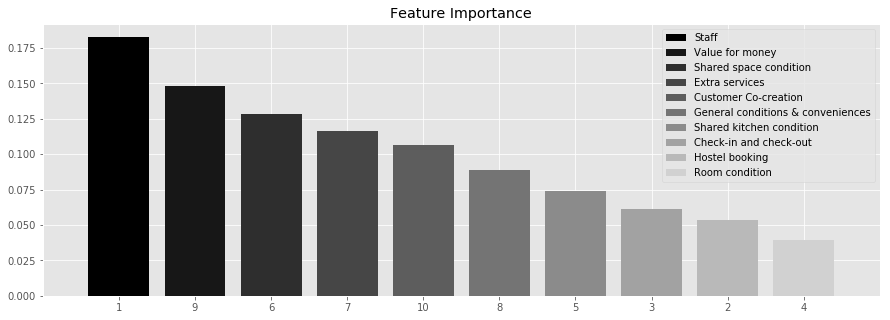

In [43]:
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1,
                          features["f"+str(feature_indices[f])],
                          importances[indices[f]]))
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot),
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1))
                       for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot),
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)])
                  for i in feature_indices])

上图表明，消费者常常更关心服务人员素质（Staff）和性价比（Value for money)，这两个因子对最终评分的影响最大。然而，这两项特征和其他特征的差别不是非常大，因此排除任何特征都会导致模型准确率的下降。

#### 梯度提升介绍

在机器学习中，有一些算法通过常被称为弱模型，这里所说的“弱模型”指的是像决策树这样简单的基本模型，也指的是那些精度相对较差的模型，也就是比随机模型好那么一点点的模型。

先来思考一个 [<i class="fa fa-external-link-square" aria-hidden="true"> 问题</i>](http://www.cis.upenn.edu/~mkearns/papers/boostnote.pdf)：是否可以从大量相对较弱和简单的模型中通过某种手段而得到一个强大的模型? 

正如你想的一样，这个问题的 [<i class="fa fa-external-link-square" aria-hidden="true"> 答案</i>](http://www.cs.princeton.edu/~schapire/papers/strengthofweak.pdf) 显然是肯定的。集成方法就是其中的一类，集成学习的算法有很多，先从最简单的开始：AdaBoost 。

 AdaBoost 采用的是一种贪婪的学习方法。在算法学习时，会给数据样本的每个都会附一个权重值，每一个基分类器开始进行分类前，都会根据前一个分类器的分类误差来调节样本的权重值。然后通线性组合的方式把所有的基分类器集成起来得到一个强分类器。整个过程可以描述为下图所示。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034245492'>

从上图中可知，在第一棵分类树（t=1）建立之后，会有三个蓝色的数据点被错分。因此在第二棵树建立的时候会增大这三个数据点的权值，以此类推。最终我们将三个基分类器结合起来，就得到了一个完美的分类器。如下图所示：

<img src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034242384' width=50%>

整个过程要是用数学公式描述的话，整个过程如下。

- 首先，给每个样本一个初始的权重值：$ w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$
- 遍历所有 $t = 1, \dots, T$
    * 训练基分类器 $ b_t$, 并令 $\epsilon_t$ 等于分类误差。
    * $\alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$
    * 更新样本权重: $ w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$
    * 归一化样本权重: $ w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$
- 返回 $\sum_t^{T}\alpha_tb_t$

当进行迭代时，可以看到误分类点权重的增加，特别是在类之间的边界上。[<i class="fa fa-external-link-square" aria-hidden="true"> 这里</i>](https://www.youtube.com/watch?v=k4G2VCuOMMg) 有一个关于 AdaBoost 的更详细的例子。

AdaBoost 分类效果确实不错，但为何这一算法如此成功却 [<i class="fa fa-external-link-square" aria-hidden="true"> 缺乏解释</i>](https://www.cs.princeton.edu/courses/archive/spring07/cos424/papers/boosting-survey.pdf)。这会让一些人持怀疑态度，认为 AdaBoost 只是过度拟合而已。

过度拟合问题也确实存在，尤其是在当数据有非常怪异的异常值时，过拟合现象较为严重。因此，在这些类型的问题中，AdaBoost 是不稳定的。为解决这些问题，1999 年，杰罗姆·弗里德曼( Jerome Friedman )提出了 AdaBoost 的泛化版本：梯度提升( Machine )，也称为 GBM 。

 CART、 bootstrap 和许多其他算法都起源于斯坦福大学的统计部门。这些算法都非常的实用，但也有一些近年来研究工作尚未得到广泛的应用。例如，[<i class="fa fa-external-link-square" aria-hidden="true"> glinternet</i>](https://arxiv.org/abs/1308.2719)。

现在关于弗里德曼的录像资料不多。不过，有一个非常有趣的 [<i class="fa fa-external-link-square" aria-hidden="true"> 访谈</i>](https://www.youtube.com/watch?v=8hupHmBVvb0)，关于如何提出 CART ，以及 CART 如何解决统计学问题。Hastie 也有一个很棒的 [<i class="fa fa-external-link-square" aria-hidden="true"> 讲座</i>](https://www.youtube.com/watch?v=zBk3PK3g-Fc)。

对于 AdaBoost 算法，虽然我们可以通过添加弱算法和逐步改进误分类数据的权值来增强集成算法。但是，这还不够，例如 GBM 不仅建立在重新加权的数据点上，而且改进了它对整体目标函数梯度的逼近。这个概念极大地打开了集成算法的研究思路。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557034239100" width=60%>

#### GBM 的历史

自从 GBM 诞生以来，经过了 10 多年的时间，它才成为数据科学工具箱中必不可少的一部分。为了应用于不同的统计问题，GBM 拥有许多的扩展版本，例如：GLMboost 和 GAMboost 用于增强已有的 GAM 模型，CoxBoost 用于存活曲线，RankBoost 和 LambdaMART 用于排序问题。

GBM 的许多实现也以不同的名称出现在不同的平台上。例如：随机 GBM、GBDT (梯度提升决策树)、GBRT (梯度提升回归树)、MART (多元加性回归树)等等。此外，由于 ML 社区又是各自为营，所以这使我们很难去知道 GBM 到底得到多广泛的应用，到底有多少个版本等问题。

同时，GBM 也在搜索排序中也得到了广泛的应用。GBM 的加入使得搜索排序被看作为一个优化损失函数问题。最初，AltaVista 是第一批引入提升排名的公司之一。但很快，这些思路就传播到了雅虎、Yandex、必应等网站。从此之后，GBM 成为了主流的算法之一，不仅用于研究，而且也广泛用于工业生产中。

<img width='200px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034236116'>

许多的机器学习竞赛，尤其是 Kaggle，在促进普及算法的应用方面发挥了重要作用。因为 Kaggle 提供了一个共同的平台，这使得数据科学家们可以在不同的数据科学问题上与来自世界各地的大量参与者竞争。人们可以在 Kaggle上用真实数据上测试新的算法，让许多算法有机会“发光”。

自 2011 年以来，在 Kaggle 的冠军访谈中，许多的获奖选手都提到自己使用了梯度提升算法。这也使得梯度提升变得流行起来。尤其是在 XGBoost 库出现之后。XGBoost 虽然不是一个新的、独特的算法，但其是一个经典 GBM 的高效实现版。

GBM 的经历与许多机器学习算法一样：从被提出到成功的实践应用和大规模使用都花了许多年的时间。

### GBM 算法

先来看一个经典的监督学习问题，假设这里有一份数据集 $ \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$ , $ x $ 表示特征值，$y$ 表示目标值。构建模型就相当于构建一个函数  $f(x)$ ，用 $f(x)$ 去逼近目标值 $ y$。定义损失函数 $L(y,f(x))$ 来表示预测值$f(x)$ 与真实值 $y$ 之间的距离。通过最小化损失函数，就可以得到：

$$ y \approx \hat{f}(x)$$

$$ \hat{f}(x) = \underset{f(x)}{\arg\min} \ L(y,f(x)) $$

<img width="600px" src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034233029'>

在这里先不管 $f(x)$ 是具体哪一个模型或某个具体的表达式，仅假定损失函数 $L(y,f(x))$ 是可微的。如果损失函数取的是整个样本的均值，则最小化损失函数可以表达为：

$$ \hat{f}(x) = \underset{f(x)}{\arg\min} \ \mathbb {E} _{x,y}[L(y,f(x))]  $$

一般情况下， $f(x)$ 的选择有很多，这意味着寻找最优的 $f(x)$ 会变得很困难。所以要对 $f(x)$ 加以限制，将其限制在一个函数空间内。假设模型的参数为 $\theta $，定义 $\theta \in \mathbb{R}^d $，则模型可描述为  $ f(x, \theta)$。所以现在寻找最优的 $f(x)$ 相当于要寻找一组参数 $\theta $ ，使得损失函数 $L(y,f(x))$ 达到最小。用公式描述如下：

$$ \hat{f}(x) = f(x, \hat{\theta})$$

$$ \hat{\theta} = \underset{\theta}{\arg\min} \ \mathbb {E} _{x,y}[L(y,f(x,\theta))] $$

由于 $f(x)$  相对比较复杂。一般情况下，解析解不存在或无法直接求得。所以要使用迭代的方法来逼近参数。定义经验损失函数为 $ L_{\theta}(\hat{\theta}) $ ，其计算公式如下：

$$ \hat{\theta} = \sum_{i = 1}^M \hat{\theta_i} $$

$$ L_{\theta}(\hat{\theta}) =  \sum_{i = 1}^N L(y_i,f(x_i, \hat{\theta}))$$  

然后,寻找一个合适的优化算法来最小化 $L_{\theta}(\hat{\theta})$ 。梯度下降是最简单和最常用的优化方法。不过，在使用梯度下降算法时，需要参数进行初始化 $\hat{\theta_0}$。并定义迭代次数 $M$。整个优化过程如下：

1. 定义参数的初始值 $\hat{\theta} = \hat{\theta}_0$
2. 对于每次迭代 $t = 1, \dots, M$ 重复步骤 3 到 7 :
1. 为当前的近似 $\hat{\theta}$ 计算损失函数的梯度值 
$\nabla L_{\theta}(\hat{\theta}) = \left[\frac{\partial L(y, f(x, \theta))}{\partial \theta}\right]_{\theta = \hat{\theta}}$
2. 通过计算梯度来设置当前的近似
$\hat{\theta_t} \leftarrow −\nabla L_{\theta}(\hat{\theta})$
3. 更新参数 
$\hat{\theta} \leftarrow \hat{\theta} + \hat{\theta_t} = \sum_{i = 0}^t \hat{\theta_i} $
3. 保存近似结果 
$\hat{\theta} = \sum_{i = 0}^M \hat{\theta_i} $
4. 得到最终的函数 $\hat{f}(x) = f(x, \hat{\theta})$

通过梯度下降优化模型的直观过程如下图所示。

<img width='700px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034230172'>

#### 函数梯度下降

在上述的推导过程中，是通过不断的迭代来更新逼近函数 $ \hat{f}(x)$ 。在函数梯度下降中，将这种逼近表述为增量改进之和，每个改进都是一个函数。

$$ \hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$$

这里假设所有的 $\hat{f_i}(x)$ 被限制在某个函数空间中，即 $\hat{f}(x) = h(x, \theta)$。最终的模型可能比这个函数空间中的任何模型都要复杂。在每一步迭代中，需要选择最优系数 $\rho_t$和 $\theta_t$ 来使 $\hat{f_t}(x)$ 达到最优。迭代过程如下。

$$ \hat{f}(x) = \sum_{i = 0}^{t-1} \hat{f_i}(x)$$

$$ (\rho_t,\theta_t) = \underset{\rho,\theta}{\arg\min} \ \mathbb {E} _{x,y}[L(y,\hat{f}(x) +  \rho \cdot h(x, \theta))]$$

$$ \hat{f_t}(x) = \rho_t \cdot h(x, \theta_t)$$

这里仅以一般形式定义了模型，如果知道了损失函数的梯度表达式，就可以通过训练数据来优化模型，使其模型的预测结果和梯度更相关。换句话说，我们将基于预测结果和这些残差的最小平方差来优化参数。因此，模型的优化可以使用以下公式描述：

$$ \hat{f}(x) = \sum_{i = 0}^{t-1} \hat{f_i}(x)$$

$$ r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad \mbox{for } i=1,\ldots,n $$

$$ \theta_t = \underset{\theta}{\arg\min} \ \sum_{i = 1}^{n} (r_{it} - h(x_i, \theta))^2$$

$$ \rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) + \rho \cdot h(x_i, \theta_t))$$

<img width='300px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034227177'>

#### Friedman 的经典 GBM 算法

在 1999 年, Jerome Friedman 提出了一种经典的 GBM 算法。它是一种监督算法，其组成部分如下:

- 数据集 $ \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$
- 迭代次数 $M$
- 损失函数 $ L(y, f)$
- 函数空间 $h(x, \theta)$ 以及训练过程。
- 函数空间 $ h(x, \theta)$ 的超参数。

因为寻找最优 $f_t(x)$ 需要知道 $f_{t-1}(x)$ 。那么 $ f_0(x)$ 是如何计算的呢？ 一般情况下，使用一个常数 $ \gamma$ 和 最优系数 $\rho $ 来搜索最优的  $ f_0(x)$ 。整个 GBM 运行过程如下：

1. 使用常数值初始化 GBM $ \hat{f}(x) = \hat{f}_0, \hat{f}_0 = \gamma,  \gamma \in \mathbb{R}$，$ \hat{f}_0 = \underset{\gamma}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \gamma)$
2. 对于每次迭代 $ t = 1, \dots, M$，重复逼近过程。
3. 计算伪残查 $r_t$，$r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad \mbox{for } i=1,\ldots,n$
4. 通过伪残差 $\left\{ (x_i, r_{it}) \right\}_{i=1, \ldots,n}$  构建基算法$h_t(x)$
5. 通过 $ h_t(x)$ 寻找最优系数。
$\rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) +  \rho \cdot h(x_i, \theta))$
6. 保存 $\hat{f_t}(x) = \rho_t \cdot h_t(x)$
7. 更新 $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f_t}(x) = \sum_{i = 0}^{t} \hat{f_i}(x)$

8. 组成最终的模型 $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x) $

#### GBM 工作原理

前面主要讲述了 GBM 的数学描述。现在通过例子来详细说明其是如何工作的。在这个例子中，需要拟合一个带噪声的函数。

$$ y = cos(x) + \epsilon, \epsilon \sim \mathcal{N}(0, \frac{1}{5}), x \in [-5,5]$$

<img width='500px' src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557034099295">

这是一个回归问题，所以损失函数选择均方误差损失函数。生成 300 对观测数据，并使用深度为 2 的决策树进行近似。 GBM 的参数设置如下:

- 数据集 $\left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}$
- 迭代次数 $M = 3$
- 均方差损失函数 $L(y, f) = (y-f)^2$
-  $ L(y, f) = L_2$ 的梯度以及残差 $r = (y - f)$
- 基算法决策树 $ h(x)$
- 决策树的超参数，树的深度为2。

对于均方差损失函数来说，初始化常数 $\gamma$ 和系数  $\rho_t$ 非常简单。仅需要将 $\rho_t$ 设置为 1，而 $\gamma$ 设置为下式即可。

$$ \gamma = \frac{1}{n} \cdot \sum_{i = 1}^n y_i $$

运行 GBM 算法，并绘制两种图形：如下图所示，蓝色的图表示当前拟合模型；绿色的图表示在伪残差上构建的每棵树。图的编号对应于迭代次数。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034096158'>

从上图可以看到，到第二次迭代时，模型已经能够拟合出数据的基本形式。然而，在第一次迭代时，算法只拟合了 $x \in [-5, -4]$ 之间的数据。这是由于决策树模型没有足够的深度来同时构建一个对称的分支，并且它首先关注误差较大的左边的分支上。因此，右分支只出现在第二次迭代之后。

由上图显示的迭代过程可知，整个过程正如预期的那。在每一步中，伪残差都在减小，而 GBM 在每次迭代中都越来越好地逼近原始数据。但是，决策树本身的构造使其不能近似连续函数，这意味着在本例中 GBM 不是最理想的。如果想要直观地理解 GBM 模型的拟合过程，可以通过一些可视化工具来进行可视化。

<img width='500px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034093292'>

### 损失函数

如果想要求解一个分类问题，而不是回归问题，那应该怎么做呢？首先选择一个合适的损失函数 $L(y,f)$ 很重要。因为损失函数决定了模型将如何优化，以及最终会得到什么样的模型。

一般来说， 并不需要自己去发明一个损失函数，这些工作研究人员已经替我们做了。现在来探索用于最常见的两种目标的损失函数：回归和二分类。

#### 回归损失函数

对于回归问题，通常对于不同的问题，不同的数据，选择的损失函数也不同。最常见的回归损失函数是

-  $ L_2$ 损失或高斯损失函数。该损失函数假定数据服从高斯分布。如果没有额外信息，也不要求模型的鲁棒性，那么可以使用该损失函数。公式如下：

$$ L(y, f) = (y - f)^2$$

- $L_1$ 损失或拉普拉斯损失。事实上它定义了条件中位数。通常，中位数对离群值的鲁棒性更好，所以这一损失函数在某些情形下也表现更好。但对大偏差的惩罚不像 $ L_2$ 那么大。公式如下：

$$ L(y, f) = |y - f|$$

- $ L_q$ 损失或分位数损失。与拉普拉斯损失相似， 只不过 $L_q$ 使用分位数而不是中位数。公式如下：

$$ \begin{equation}  L(y, f) =\left\{   \begin{array}{@{}ll@{}}     (1 - \alpha) \cdot |y - f|, & \text{if}\ y-f \leq 0 \\     \alpha \cdot |y - f|, & \text{if}\ y-f >0  \end{array}\right. \end{equation}, \alpha \in (0,1)$$

这三种损失函数的函数图如下图所示。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034090224'>

使用 $L_q$ 损失函数来进行实验，继续使用前文所构建的数据。GBM 的实验参数设置如下：

- 数据 $\left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}$
- 迭代次数 $ M = 3$
- 损失函数 $  \begin{equation} L_{0.75}(y, f) =\left\{
\begin{array}{@{}ll@{}} 0.25 \cdot |y - f|, & \text{if}\ y-f \leq 0 \\     0.75 \cdot |y - f|, & \text{if}\ y-f >0   \end{array}\right. \end{equation} $
- 梯度 $L_{0.75}(y, f)$, $\alpha = 0.7$
- 基算法 $ h(x)$ 为决策树。
- 决策树超参数：depth = 2。

第一次逼近需要 $y$ 的分位数，但这里并不知道最佳参数该取什么值，所以使用标准的线搜索来求出。模型迭代过程如下：

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034189167'>

我们可以看到，使用分位数作为损失函数的 GBM 能够很好的拟合初始数据。

通常情况下， 使用 $L_q$ 损失函数的 GBM 的结果等价于使用 $L_2$ 损失函数的 GBM 加上约 0.135 的偏置。但是如果使用的是 90% 分位数的话，那我们将没有足够的数据，因为样本类别变得极不平衡。在处理非标准问题时，需要记住这一点。



人们为回归任务开发了许多损失函数。例如，鲁棒性极强的 [<i class="fa fa-external-link-square" aria-hidden="true"> Huber 损失函数</i>](https://en.wikipedia.org/wiki/Huber_loss)。对于少数异常值，Huber 损失函数的工作方式是 $ L_2$，但异常值超过阈值之后，损失函数将更改为$L_1$。这会减少异常值的影响，并更加关注整体情况。

为了更好理解损失函数，通过一个例子来说明。首先，实验数据由函数 $ y = \frac{sin(x)}{x}$ 生成，并添加来自正常分布和 Bernulli 分布的混合噪声。图 A-D 显示的是损失函数，图 F-H 显示的是相应的 GBM 拟合过程。

<img width='600px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034086503'>

在这个例子中，使用样条曲线作为基算法。这也说明了，梯度提升中的基算法不一定是决策树。

从上图中可以清楚地看到 $L_2$ 损失函数、$L_1$ 损失函数和 Huber 损失函数之间的区别。如果我们为 Huber 损失函数选择最优的参数，则可以得到更好的拟合。

虽然 Huber 损失函数的效果很好。但是，Huber 损失函数只被非常少的流行库支持。例如，XGBoost 不支持。

#### 分类损失函数

现在，让我们看看二进制分类问题 $ y \in \left\{- 1,1 \right\}$。从技术上讲，此类问题也可以使用 $ L_2$ 损失来解决这个问题，但是这不是正规的做法。

目标变量的分布 $ y \in \left\{- 1,1 \right\}$ 要求损失函数需要使用对数似然，常见的对数似然损失函数如下:

- 逻辑损失或伯努利损失。该损失函数不仅要优化损失，同时要类别之间区别得更开。所以它甚至会惩罚正确预测的分类。公式如下：

$$ L(y, f) = log(1 + exp(-2yf))$$ 

- AdaBoost 损失。 与逻辑损失相似，但对错误的预测有更为严重的指数惩罚。

$$ L(y, f) = exp(-yf)$$

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034017468'>

现在来看一个例子。使用符号函数构建实验数据，如下图所示：

<img width='500px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034013933'>

先来探索将逻辑损失作为损失函数的模型。GBM 的实验参数如下：

- 实验数据：$\left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}, y_i \in \left\{-1, 1\right\}$ 
- 迭代次数：$M = 3$
- 损失函数为逻辑损失函数, 其梯度为：$ r_{i} = \frac{2 \cdot y_i}{1 + exp(2 \cdot y_i \cdot \hat{f}(x_i)) }, \quad \mbox{for } i=1,\ldots,300$
- 基算法为决策树：$ h(x)$
- 决策树的超参数：depth = 2。

这个例子中，算法的初始化有点困难。首先，数据的类别不平衡，负类为 63%，正类为 37%。其次，损失函数的初始化没有已知的解析公式，所以只能通过搜索来查找 $ \hat{f_0} = \gamma$，不同 $\gamma$ 值对应的损失函数值如下图所示。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034009601'>

由上图可知，最优初始近似是 -0.273 左右。你可能已经猜到它是负数，因为样本中负类的数量要比正类多很多。接下来对 GBM 模型进行优化，过程如下：

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034006567'>

如上图所示，该算法成功地将红色点数据和蓝色点数据分离。你可以看到“较低”区域是如何分隔的，因为决策树更容易正确预测负类。此外，还可以看到模型如何拟合混合分类。很明显，模型得到了大量正确分类的观测，一些误差较大的观测则可能是数据中的噪声所导致的。

#### 权重

有时候，我们需要一个更具体的损失函数来解决问题。例如，在金融时间序列中，我们可能想要给予时间序列中较大的波动更大的权重。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557034003691'>

有些人可能想要发明他们自己的损失函数，写出它的梯度，并仔细检查这个函数是否满足所需的属性。然而，有很大的几率会在某处犯下错误，导致计算困难，花费过量时间来排除错误。

针对这一问题，人们提出了一种非常简单的做法：对数据或预测结果进行加权。例如，如果知道数据的某个子集对模型更重要，那么可以直接给它们分配较大的权重 $w(x, y)$。权重通常需满足以下条件：

$$ w_i \in \mathbb{R}, $$

$$ w_i \geq 0 \quad \mbox{for } i=1,\ldots,n$$

$$ \sum_{i = 1}^n w_i > 0 $$

加权能够显著降低调整损失函数的时间。此外，这还可以充分发挥你的创造性。比如，简单地给损失函数或残差加上标量权重：

$$  L_{w}(y,f) = w \cdot L(y,f)$$

$$ r_{it} =   - w_i \cdot \left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)} \quad \mbox{for } i=1,\ldots,n$$

很明显，对于任意权重，我们并不知道模型的统计学性质。通常，将权重与 $y$ 值联系起来可能会变得过于复杂。例如，使用正比于 $|y|$ 的权重在 $L1$ 损失和 $L2$ 损失中是不等价的，因为梯度不考虑预测本身的值: $\hat{f}(x)$。

先通过定义一个非对称的加权函数来为数据添加一些非常奇特的权重。函数表达式如下:

$$ \begin{equation} w(x) =\left\{   \begin{array}{@{}ll@{}}     0.1, & \text{if}\ x \leq 0 \\     0.1 + |cos(x)|, & \text{if}\ x >0 \end{array}\right. \end{equation} $$

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033837228'>

通过这些权重，我们希望得到两个属性: $x$ 的负值细节更少和形成类似于初始余弦的函数。这里使用上一个例子的 GBM 模型，得到的结果如下:

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033832894'>

从上图可知，基本达到了预期的结果。首先，第一次迭代上的伪残差有着很大的误差，它们看起来几乎像原本的余弦函数，如 0.E 图所示。其次，函数图的左侧往往被忽略，而右侧的权重更大，这也与我们给予数据的权重相吻合。最后，第三次迭代得到的函数看起来和原本的余弦函数类似，同时也开始有点过拟合了。

加权是一个强大但有风险的工具。可以使用它来控制模型的属性。如果你想优化损失函数，可以先尝试对观测结果进行加权。

#### 过拟合

在本文中，我们有意省略了有关 GBM 正则化、随机性和超参数的问题，且在整个过程中仅使用了少 3 次迭代，这也并非偶然。如果使用 30 棵树而不是 3 棵，模型可能会因为复杂都过高而过拟合。

一般情况下，良好的拟合如下图所示。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033829216'>

如果模型在训练时过度关注那些异常值点，这往往也会导致其过拟合，如下图所示。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033825292'>

30 棵决策树的拟合结果如下图所示，在训练集上得损失为 0 ，而在测试集上得损失为 0.664。这说明模型在训练集上过拟合了。

<img width='400px' src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557033819881'>

### 实验总结

本次实验简要介绍了机器学习中一个重要的技术：集成学习，文中介绍的 Bootstraping、Bagging、随机森林都是较为成熟好用的方法。通过随机森林衡量特征的重要性，能更好的帮助大家分析自己所构建的模型。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i>
- [<i class="fa fa-external-link-square" aria-hidden="true"> 统计学习</i>](https://statweb.stanford.edu/~tibs/ElemStatLearn/)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 随机森林原论文</i>](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
- [<i class="fa fa-external-link-square" aria-hidden="true"> GBM 教程</i>](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 梯度提升树介绍</i>](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf) 
- [<i class="fa fa-external-link-square" aria-hidden="true"> 梯度提升-维基百科</i>](https://en.wikipedia.org/wiki/Gradient_boosting)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 了解实验楼《楼+ 机器学习和数据挖掘课程》</i>](https://www.shiyanlou.com/louplus/)